----------------------------
# Trabajo Final de Redes Neuronales
----------------------------

In [ ]:
# %pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
# from torchviz import make_dot, make_dot_from_trace

In [ ]:
# %pip install visualkeras

In [1]:
import os
import pickle
import datetime
from collections import defaultdict
# import visualkeras

In [2]:
# from PIL import ImageFont

In [3]:

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
# import dill
import json

In [4]:
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.init as init
#from torchviz import make_dot
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns
# from torchviz import make_dot

In [5]:
import google.colab
from google.colab import files

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Primera parte: Autoencoder

In [7]:
# Descargamos los datos y los tranformamos en tensores

transform = transforms.Compose([transforms.ToTensor()
                                # ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

trainset_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

trainset = trainset_orig
testset = testset_orig

100%|██████████| 26421880/26421880 [00:02<00:00, 9720064.19it/s] 


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173455.55it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3199590.14it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22468550.46it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [8]:
# Creamos un diccionario con los labels de los elementos

# labels_names = {
#     0: "T-Shirt",    # Remera manga corta
#     1: "Trouser",    # Pantalon
#     2: "Pullover",   # Buzo
#     3: "Dress",      # Vestido
#     4: "Coat",       # Abrigo
#     5: "Sandal",     # Sandalia
#     6: "Shirt",      # Remera manga larga
#     7: "Sneaker",    # Zapatilla
#     8: "Bag",        # Bolso
#     9: "Ankle Boot", # Bota
# }

labels_names = {
    0: "Manga corta",  # Remera manga corta
    1: "Pantalon",     # Pantalon
    2: "Buzo",         # Buzo
    3: "Vestido",      # Vestido
    4: "Abrigo",       # Abrigo
    5: "Sandalia",     # Sandalia
    6: "Manga larga",  # Remera manga larga
    7: "Zapatilla",    # Zapatilla
    8: "Bolso",        # Bolso
    9: "Bota",         # Bota
}

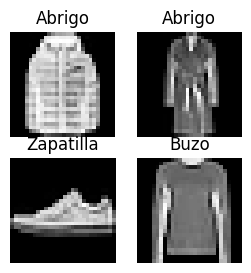

In [9]:
# Graficamos alfunas muestras
figure = plt.figure(figsize = (3,3))
cols,rows = 2,2
for i in range(1,cols*rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = trainset[j]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

In [ ]:
trainset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

## Creamos un autoencoder

In [10]:
# Creamos una subclase de Dataset que nos sirva para muestrar imagenes en el entrenamiento del autoencoder

class CustomDataset(Dataset):
    def __init__(self,dataset):
      self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
      return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
      image, label = self.dataset[i]
      input  = image
      output = image
      return input,output

In [11]:
# Nos definimos la red Autoencoder con varia capas, la vamos a separa en una parte encoder y otra decoder
class Autoencoder(nn.Module):
    def __init__(self,n,p):
        super(Autoencoder,self).__init__()
        self.flatten = nn.Flatten()
        self.n = n
        self.p = p
        self.encoder = nn.Sequential(
            # Capa convolucional 2D compuesta
            nn.Conv2d(1,16,kernel_size=3),  #  Dim: (1,28,28) --> (16,26,26)
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Dropout(self.p),
            nn.MaxPool2d(2,2),  # Dim:  (16,26,26) --> (16,13,13). nn.MaxPool2d se crea con un tamaño de kernel de 2x2 y un paso de 2.
            # Otra capa 2D convolucional compuesta
            nn.Conv2d(16,32,kernel_size=3), # Dim: (16,13,13) --> (32,11,11)
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Dropout(self.p),
            nn.MaxPool2d(2,2),  # Dim: (32,11,11) --> (32,5,5)
            # Capa lineal compuesta:
            nn.Flatten(),  # Dim: (32,5,5) --> 32*5*5
            nn.Linear(32*5*5,self.n),  # Dim: 32*5*5 --> n
            # nn.ReLU(),
            nn.Sigmoid(),
            nn.Dropout(self.p),
         )
        self.decoder = nn.Sequential(
            # Capa lineal
            nn.Linear(self.n,32*5*5),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Dropout(self.p),
            nn.Unflatten(1,(32,5,5)), # Dim: 32*5*5 --> (32,5,5)
            # Capa convolucional 2D transpuesta, de la segunda convolucional
            nn.ConvTranspose2d(32,16,kernel_size=(4,4),stride=(2,2),output_padding=(1,1)), # Dim: (32,5,5) --> (16,13,13)
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Dropout(self.p),
            # Capa convolucional traspuesta, para la primera convolucional
            nn.ConvTranspose2d(16,1,kernel_size=(3,3),stride=(2,2),output_padding=(1,1)),  # Dim:  (16,13,13) --> (1,28,28)
            nn.Sigmoid(),
            # nn.ReLU(),
            # nn.Softmax(),
            nn.Dropout(self.p),
        )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    # def reset_weights(self):
    #     for param in self.parameters():
    #         if param.requires_grad:
    #             if len(param.shape) > 1:
    #                 init.xavier_uniform_(param.data)
    #             else:
    #                 init.zeros_(param.data)

In [12]:
# Creamos el model# Convertimos FashionMNIST Dataset a CustomDataset para
trainset = CustomDataset(trainset)
testset  = CustomDataset(testset)

In [13]:
# Creamos el modelo
n = 256
p = 0.2
model = Autoencoder(n,p)

In [14]:
# Creamos para redimensionalizar las figuras
def batch(x):
  return x.unsqueeze(0)  # (28,28) --> (1,28,28)

def unbatch(x):
  return x.squeeze().detach().cpu().numpy()  # (1,28,28) --> (28,28)

## Red sin entrenar

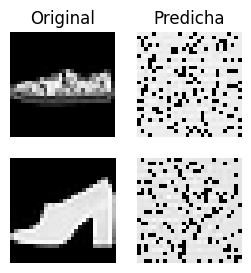

In [15]:
# Miramos que imagenes predice el modelo sin entrenar
figure = plt.figure(figsize = (3,3))
rows,cols = 2,2
i = 0 # subplot index
for row in range(1,rows+1):
  j = torch.randint(len(trainset),size=(1,)).item() # Generamos un número aleatorio con torch.
  #Ploteamos la imagen original
  i += 1
  image,_ = trainset[j]
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('Original')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')
  # Ploteamos la imagen predicha
  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('Predicha')
  plt.axis('off')
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap='Greys_r')
plt.show()

In [16]:
# Definimos los loops de entrenamiento

def train_loop(dataloader,model,loss_fn,optimizer):
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_train_loss = 0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Movemos el lote a la GPU
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_batch = loss.item()
        sum_train_loss += loss_batch
        if batch*batch_size % 5000 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    avg_train_loss = sum_train_loss/num_batches
    return avg_train_loss

# De manera similar, definimos la función de testeo
def valid_loop(dataloader,model,loss_fn):
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_test_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Movemos el lote a la GPU
            X,y = X.to(device),y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            loss_batch = loss_fn(pred,y).item()
            sum_test_loss += loss_batch
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            #sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_test_loss = sum_test_loss/num_batches
    #frac_correct = sum_correct/size
    #print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")
    print(f"Test Error: Avg loss: {avg_test_loss:>8f} \n")
    return avg_test_loss

In [17]:
learning_rate = 1e-3
batch_size    = 100

In [18]:
# Creamos los DataLoaders
# trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

Red con 256 neuronas en la capa intermedia
------------------------------
Epoch 1
------------------------------
batch=0 loss=0.222883  muestras-procesadas:[    0/50000]
batch=50 loss=0.152753  muestras-procesadas:[ 5000/50000]
batch=100 loss=0.121163  muestras-procesadas:[10000/50000]
batch=150 loss=0.110963  muestras-procesadas:[15000/50000]
batch=200 loss=0.107582  muestras-procesadas:[20000/50000]
batch=250 loss=0.101820  muestras-procesadas:[25000/50000]
batch=300 loss=0.095316  muestras-procesadas:[30000/50000]
batch=350 loss=0.098059  muestras-procesadas:[35000/50000]
batch=400 loss=0.097341  muestras-procesadas:[40000/50000]
batch=450 loss=0.093574  muestras-procesadas:[45000/50000]
Test Error: Avg loss: 0.058105 

Test Error: Avg loss: 0.058024 

Epoch 2
------------------------------
batch=0 loss=0.097899  muestras-procesadas:[    0/50000]
batch=50 loss=0.089778  muestras-procesadas:[ 5000/50000]
batch=100 loss=0.081876  muestras-procesadas:[10000/50000]
batch=150 loss=0.0842

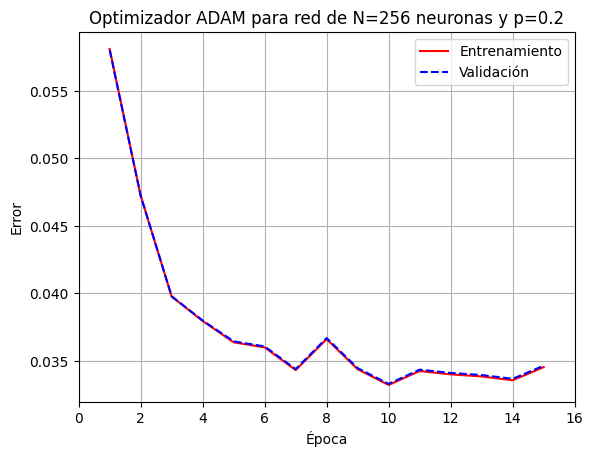

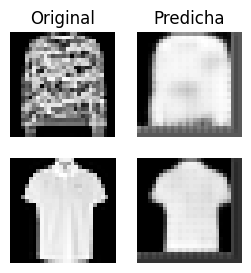

Done!


In [19]:
# # Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 15
list_avg_train_loss = []
list_avg_test_train_loss = []
list_avg_test_loss = []
error_testeo = []

N = [ 256 ]
P = [ 0.2 ]

loss_fn = nn.MSELoss() # Para autoencoder
# loss_fn = nn.BCELoss()

for n,p in zip(N,P):

   model = Autoencoder(n,p)

   temp_avg_train_loss      = []
   temp_avg_test_train_loss = []
   temp_avg_test_loss       = []

   train_data, val_data = random_split(trainset, [50000, 10000])

   train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
   val_loader   = DataLoader(val_data, batch_size   = batch_size, shuffle = True)

   print('Red con '+str(n)+' neuronas en la capa intermedia\n------------------------------')
   for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n------------------------------")


      # El tipo de método que usamos para optimizar la red
      optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
      # optimizer = torch.optim.SGD(model.parameters(),lr=0.5,momentum=0.9)


      avg_train_loss      = train_loop(train_loader,model,loss_fn,optimizer)
      avg_test_train_loss = valid_loop(train_loader,model,loss_fn)
      avg_test_loss       = valid_loop(val_loader,model,loss_fn)

      list_avg_train_loss.append(avg_train_loss)
      list_avg_test_train_loss.append(avg_test_train_loss)
      list_avg_test_loss.append(avg_test_loss)

      temp_avg_train_loss.append(avg_train_loss)
      temp_avg_test_train_loss.append(avg_test_train_loss)
      temp_avg_test_loss.append(avg_test_loss)

  # Calculamos los errores en datos que nunca vió la Red
   test_loss       = valid_loop(testloader,model,loss_fn)
   error_testeo.append(test_loss)

 #  Graficamos la evoición del error con las épocas
   plt.xlabel('Época')
   plt.ylabel('Error')
   plt.xlim(0,num_epochs+1)
  # plt.ylim(0,0.024)
  # plt.plot(list(range(1,len(temp_avg_train_loss)+1)),temp_avg_train_loss,label="train",linestyle='-.',c='green')
   plt.plot(list(range(1,len(temp_avg_test_train_loss)+1)),temp_avg_test_train_loss,label="Entrenamiento",linestyle='-',c='red')
   plt.plot(list(range(1,len(temp_avg_test_loss)+1)),temp_avg_test_loss,label="Validación",linestyle='--',c='blue')
   plt.title('Optimizador ADAM para red de N='+str(n)+' neuronas y p='+str(p))
   plt.grid()
   plt.legend()
   plt.show()

   # Miramos que imagenes predice el modelo entrenado
   figure = plt.figure(figsize = (3,3))
   rows,cols = 2,2
   i = 0 # subplot index
   model.eval()
   for row in range(1,rows+1):
     j = torch.randint(len(testset),size=(1,)).item() # Generamos un número aleatorio con torch.
     #Ploteamos la imagen original
     i += 1
     image,_ = testset[j]
     figure.add_subplot(rows,cols,i)
     if row == 1:
       plt.title('Original')
     plt.axis('off')
     plt.imshow(unbatch(image),cmap='Greys_r')
     # Ploteamos la imagen predicha
     i += 1
     figure.add_subplot(rows,cols,i)
     if row == 1:
       plt.title('Predicha')
     plt.axis('off')
     with torch.no_grad():
         image_gpu = image.to(device)
     pred_gpu = unbatch(model(batch(image_gpu)))
    #  pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
     plt.imshow(pred_gpu,cmap="Greys_r")
   plt.show()

print("Done!")


# fig,ax = plt.subplots()

# plt.xlabel('Cantidad de Neuronas')
# plt.ylabel('Error')
# # Ploteamos el error global para los distintos tamaños de la red oculta
# plt.scatter(N,error_testeo,label="Testeo",c='b')
# ax.set_xticks(range(0,512+2*64,64))
# # ax.set_xticklabels(N)
# # plt.plot(list(range(1,len(temp_avg_test_loss)+1)),temp_avg_test_loss,label="validación",linestyle='--',c='blue')
# plt.title('Error final para distintos N')
# plt.grid()
# plt.legend()
# plt.show()


In [20]:
# Error de testeo para el modelo
error_testeo

[0.034704223349690436]

------------------------------------------------
## Lo que sigue es para encontrar la época óptima, que ya dió 16.
------------------------------------------------

In [ ]:
# Ralizamos un promedio de los errores de validación de las diferentes épocas para calcular la óptima

# lista original
loss_entrenamiento = list_avg_test_train_loss

loss_validacion    = list_avg_test_loss

# Número de elementos por sublista
tamano_sublista = num_epochs

# Dividir la lista en sublistas de 30 elementos
entrenamiento_loss = [loss_entrenamiento[i:i+tamano_sublista] for i in range(0, len(loss_entrenamiento), tamano_sublista)]

validacion_loss   =  [loss_validacion[i:i+tamano_sublista] for i in range(0, len(loss_validacion), tamano_sublista)]

# Creamos una lista con los datos promediados de las 10 corridas

validacion_loss_tot = [ (elem1+elem2+elem3+elem4+elem5+elem6+elem7+elem8+elem9+elem10)/10 for elem1,elem2,elem3,elem4,elem5,elem6,elem7,elem8,elem9,elem10 in zip(validacion_loss[0],validacion_loss[1],validacion_loss[2],validacion_loss[3],validacion_loss[4],validacion_loss[5],validacion_loss[6],validacion_loss[7],validacion_loss[8],validacion_loss[9]) ]

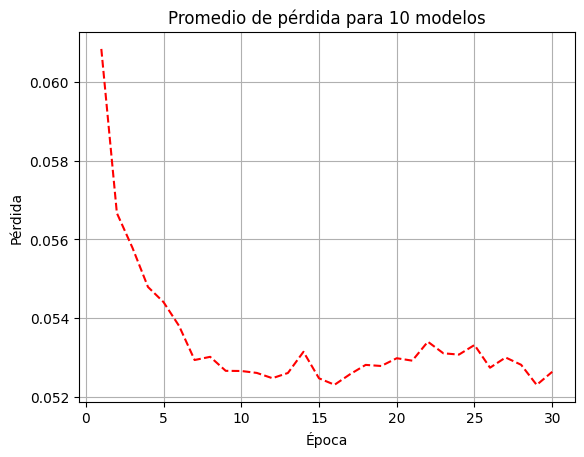

In [ ]:
# La mejor época es la 16, vamos a entrenar hasta ahí el modelo

plt.xlabel('Época')
plt.ylabel('Pérdida')
# plt.xlim(40,50)
# plt.ylim(0,0.024)
plt.title('Promedio de pérdida para 10 modelos')

# plt.plot(list(range(1,len(entrenamiento_loss[0])+1)),entrenamiento_loss[0],label="entrenamiento",linestyle='-',c='red')
plt.plot(list(range(1,len(validacion_loss_tot)+1)),validacion_loss_tot,label="N=64",linestyle='--',c='red')

# # plt.plot(list(range(1,len(entrenamiento_loss[1])+1)),entrenamiento_loss[1],label="entrenamiento",linestyle='-',c='blue')
# plt.plot(list(range(1,len(validacion_loss[1])+1)),validacion_loss[1],label="N=128",linestyle='--',c='blue')

# # plt.plot(list(range(1,len(entrenamiento_loss[2])+1)),entrenamiento_loss[2],label="entrenamiento",linestyle='-',c='g')
# plt.plot(list(range(1,len(validacion_loss[2])+1)),validacion_loss[2],label="N=256",linestyle='--',c='g')

# # plt.plot(list(range(1,len(entrenamiento_loss[3])+1)),entrenamiento_loss[3],label="entrenamiento",linestyle='-',c='k')
# plt.plot(list(range(1,len(validacion_loss[3])+1)),validacion_loss[3],label="N=512",linestyle='--',c='k')

plt.grid()
# plt.legend()
plt.show()

In [ ]:
#  Nos ayuda a resetear los parámetros del modelo entrenado
# model.reset_weights()

 --------------------------------------------------------

## Corremos el modelo hasta la época óptima y guardamos la parte encoder del autoencoder. Pero hay que engobarlo con el clasificador
-----------------------------------------------------------------------

In [ ]:
# Guardamos el autoencoder entrenado
# torch.save(model, 'Autoencoder_entrenado_n_64_p_02_V3.pth')


# Saving model
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('Autoencoder_n_64_p_02_epocas_15_V2.pt') # Save

# Segunda parte: Clasificador convolucional reutilizando el encoder

In [21]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))j
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset  = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [22]:
# Definimos las etiquetas
# labels_names = {
#     0: "T-Shirt",    # Remera manga corta
#     1: "Trouser",    # Pantalon
#     2: "Pullover",   # Buzo
#     3: "Dress",      # Vestido
#     4: "Coat",       # Abrigo
#     5: "Sandal",     # Sandalia
#     6: "Shirt",      # Remera manga larga
#     7: "Sneaker",    # Zapatilla
#     8: "Bag",        # Bolso
#     9: "Ankle Boot", # Bota
# }

labels_names = {
    0: "Manga corta",# Remera manga corta
    1: "Pantalon",   # Pantalon
    2: "Buzo",       # Buzo
    3: "Vestido",      # Vestido
    4: "Abrigo",       # Abrigo
    5: "Sandalia",     # Sandalia
    6: "Manga larga",      # Remera manga larga
    7: "Zapatilla",    # Zapatilla
    8: "Bolso",        # Bolso
    9: "Bota", # Bota
}

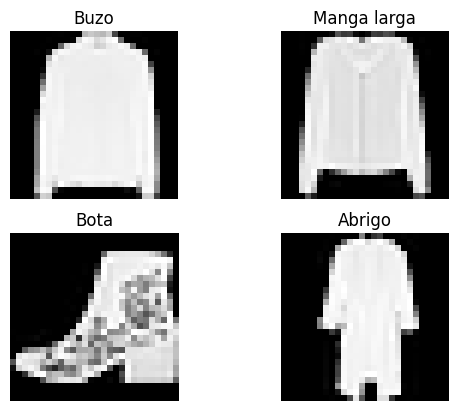

In [23]:
# Graficamos las muestras con sus etiquetas
figure = plt.figure()
cols,rows = 2,2
for i in range(1,cols*rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = trainset[j]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

In [ ]:
# Cargar los pesos del encoder en el clasificador
# encoder_weights = torch.load('Autoencoder_n_256_p_02_epocas_16.pt')
# clasificador.encoder.load_state_dict(encoder_weights)

In [24]:
class Clasificador(nn.Module):
     def __init__(self,encoder):
         super(Clasificador,self).__init__()
         self.flatten = nn.Flatten()
         self.encoder = encoder
         self.cl      = nn.Sequential(
             nn.Linear(256,10),
             nn.ReLU(),
            #  nn.Sigmoid(),
            #  nn.Softmax(),
            #  nn.Dropout(0.2),
         )
     def forward(self,x):
         x = self.encoder(x)
         x = self.cl(x)
         return x

In [25]:
# Cargar los pesos del encoder en el clasificador
# autoencoder_load = torch.load('Autoencoder_entrenado_n_64_p_02_V3.pth')
# autoencoder_load.eval()
# encoder_weights = autoencoder_load.encoder

# model = torch.jit.load('Autoencoder_n_256_p_02_epocas_16.pt')
model.eval()
encoder_weights = model.encoder

In [ ]:
# Si queremos ver la red que creamos

# output_tensor,_ = trainset[1]
# clasificador = Clasificador(model.encoder)
# make_dot(clasificador(batch(output_tensor)), params=dict(model.named_parameters())).render("Clasificador", format="png", cleanup=True)

In [26]:
# Definimos las funciones loop

def train_loop(dataloader,model,loss_fn,optimizer):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_value = loss.item()
        sum_loss += loss_value
        # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 100 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss_value:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    avg_loss = sum_loss/num_batches
    frac_correct = sum_correct/size
    return avg_loss,frac_correct


def valid_loop(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_loss = sum_loss/num_batches
    frac_correct = sum_correct/size
    print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
    return avg_loss,frac_correct

In [29]:
# Creamos la función pérdida
loss_fn = nn.CrossEntropyLoss()

# Creamos el optimizador
learning_rate = 1e-3
batch_size    = 64

In [30]:
num_epochs = 15
list_avg_train_loss = []
list_avg_test_train_loss = []
list_avg_test_loss = []
error_testeo = []

N = [ 256 ]
P = [ 0.2 ]

for n,p in zip(N,P):

   clasificador = Clasificador(encoder_weights)

   # El tipo de método que usamos para optimizar la red
   optimizer = torch.optim.Adam(clasificador.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
  #  optimizer = torch.optim.SGD(clasificador.parameters(),lr=learning_rate,momentum=0.9)

   temp_avg_train_loss      = []
   temp_avg_test_train_loss = []
   temp_avg_test_loss       = []

   train_data, val_data = random_split(trainset, [50000, 10000])

   train_loader = DataLoader(train_data, batch_size   = batch_size, shuffle = True)
   val_loader   = DataLoader(val_data,   batch_size   = batch_size, shuffle = True)
   testloader   = DataLoader(testset,    batch_size   = batch_size, shuffle = True)

   print('Red con '+str(n)+' neuronas en la capa intermedia\n------------------------------')
   for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n------------------------------")


      # # El tipo de método que usamos para optimizar la red
      optimizer = torch.optim.Adam(clasificador.cl.parameters(),lr=learning_rate,eps=1e-08,weight_decay=learning_rate,amsgrad=False)

      avg_train_loss      = train_loop(train_loader,clasificador,loss_fn,optimizer)
      avg_test_train_loss = valid_loop(train_loader,clasificador,loss_fn)
      avg_test_loss       = valid_loop(val_loader,clasificador,loss_fn)

      list_avg_train_loss.append(avg_train_loss)
      list_avg_test_train_loss.append(avg_test_train_loss)
      list_avg_test_loss.append(avg_test_loss)

      temp_avg_train_loss.append(avg_train_loss)
      temp_avg_test_train_loss.append(avg_test_train_loss)
      temp_avg_test_loss.append(avg_test_loss)

  # Calculamos los errores en datos que nunca vió la Red
   test_loss       = valid_loop(testloader,clasificador,loss_fn)
   error_testeo.append(test_loss)

 # Nos definimos los errores del modelo y la precisión, para entrenamiento
   error_modelo_entrenamiento = [temp_avg_test_train_loss[i][0] for i in range(len(temp_avg_test_train_loss))]
   precision_entrenamiento    = [temp_avg_test_train_loss[i][1] for i in range(len(temp_avg_test_train_loss))]

  #  Nos definimos los errores del modelo y la precisión, para validación
   error_modelo_validacion = [temp_avg_test_loss[i][0] for i in range(len(temp_avg_test_loss))]
   precision_validacion    = [temp_avg_test_loss[i][1] for i in range(len(temp_avg_test_loss))]

 #  Graficamos la evolución del error con las épocas (del modelos)
   plt.xlabel('Época')
   plt.ylabel('Error')
   plt.xlim(0,num_epochs+1)
  # plt.ylim(0,0.024)
  # plt.plot(list(range(1,len(temp_avg_train_loss)+1)),temp_avg_train_loss,label="train",linestyle='-.',c='green')
   plt.plot(list(range(1,len(error_modelo_entrenamiento)+1)),error_modelo_entrenamiento,label="Entrenamiento",linestyle='-',c='red')
   plt.plot(list(range(1,len(error_modelo_validacion)+1)),error_modelo_validacion,label="Validación",linestyle='--',c='blue')
   plt.title('Optimizador ADAM para red de N='+str(n)+'.')
   plt.grid()
   plt.legend()
   plt.show()

 #  Graficamos la evolución de precision con las épocas (del modelos)
   plt.xlabel('Época')
   plt.ylabel('Exactitud')
   plt.xlim(0,num_epochs+1)
  # plt.ylim(0,0.024)
  # plt.plot(list(range(1,len(temp_avg_train_loss)+1)),temp_avg_train_loss,label="train",linestyle='-.',c='green')
   plt.plot(list(range(1,len(precision_entrenamiento)+1)),precision_entrenamiento,label="Entrenamiento",linestyle='-',c='red')
   plt.plot(list(range(1,len(precision_validacion)+1)),precision_validacion,label="Validación",linestyle='--',c='blue')
   plt.title('Optimizador ADAM para red de N='+str(n)+'.')
   plt.grid()
   plt.legend(loc='lower right')
   plt.show()

  #  # Miramos que imagenes predice el modelo entrenado
  #  figure = plt.figure(figsize = (3,3))
  #  rows,cols = 2,2
  #  i = 0 # subplot index
  #  clasificador.eval()
  #  for row in range(1,rows+1):
  #    j = torch.randint(len(testset),size=(1,)).item() # Generamos un número aleatorio con torch.
  #    #Ploteamos la imagen original
  #    i += 1
  #    image,_ = testset[j]
  #    figure.add_subplot(rows,cols,i)
  #    if row == 1:
  #      plt.title('Original')
  #    plt.axis('off')
  #    plt.imshow(unbatch(image),cmap='Greys_r')
  #    # Ploteamos la imagen predicha
  #    i += 1
  #    figure.add_subplot(rows,cols,i)
  #    if row == 1:
  #      plt.title('Predicha')
  #    plt.axis('off')
  #    with torch.no_grad():
  #        image_gpu = image.to(device)
  #    pred_gpu = unbatch(clasificador(batch(image_gpu)))
  #   #  pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
  #    plt.imshow(pred_gpu,cmap="Greys_r")
  #  plt.show()


print("Done!")

Red con 256 neuronas en la capa intermedia
------------------------------
Epoch 1
------------------------------
batch=0 loss=2.296479  muestras-procesadas:[    0/50000]
batch=100 loss=1.765513  muestras-procesadas:[ 6400/50000]
batch=200 loss=1.331711  muestras-procesadas:[12800/50000]
batch=300 loss=1.212353  muestras-procesadas:[19200/50000]
batch=400 loss=1.281725  muestras-procesadas:[25600/50000]
batch=500 loss=1.173258  muestras-procesadas:[32000/50000]
batch=600 loss=1.365220  muestras-procesadas:[38400/50000]
batch=700 loss=1.063266  muestras-procesadas:[44800/50000]
Test Error: 
 Accuracy: 66.1%, Avg loss: 1.096169 

Test Error: 
 Accuracy: 66.5%, Avg loss: 1.082940 

Epoch 2
------------------------------
batch=0 loss=1.099729  muestras-procesadas:[    0/50000]
batch=100 loss=1.101935  muestras-procesadas:[ 6400/50000]
batch=200 loss=1.145413  muestras-procesadas:[12800/50000]
batch=300 loss=1.347878  muestras-procesadas:[19200/50000]
batch=400 loss=1.063786  muestras-proces

KeyboardInterrupt: ignored

In [ ]:
error_testeo

[(0.695246387720108, 0.7771)]

In [ ]:
# Saving model
model_scripted = torch.jit.script(clasificador) # Export to TorchScript
model_scripted.save('Clasificador_n_256_p_01_epocas_5.pt') # Save

# Tercera parte: Armamos la matriz de confusión

In [ ]:
# Descargamos los datos de Fashion-MINST

transform = transforms.Compose([transforms.ToTensor()
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))j
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset  = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [ ]:
# Cargamos el claisficador
clasificador = torch.jit.load('Clasificador_n_64_p_02_epocas_30.pt')
clasificador.eval()

RecursiveScriptModule(
  original_name=Clasificador
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (encoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Dropout)
    (3): RecursiveScriptModule(original_name=MaxPool2d)
    (4): RecursiveScriptModule(original_name=Conv2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Dropout)
    (7): RecursiveScriptModule(original_name=MaxPool2d)
    (8): RecursiveScriptModule(original_name=Flatten)
    (9): RecursiveScriptModule(original_name=Linear)
    (10): RecursiveScriptModule(original_name=ReLU)
    (11): RecursiveScriptModule(original_name=Dropout)
  )
  (cl): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): Recurs

In [ ]:
# Definimos las etiquetas
# labels_names = {
#     0: "T-Shirt",    # Remera manga corta
#     1: "Trouser",    # Pantalon
#     2: "Pullover",   # Buzo
#     3: "Dress",      # Vestido
#     4: "Coat",       # Abrigo
#     5: "Sandal",     # Sandalia
#     6: "Shirt",      # Remera manga larga
#     7: "Sneaker",    # Zapatilla
#     8: "Bag",        # Bolso
#     9: "Ankle Boot", # Bota
# }

labels_names = {
    0: "Manga corta",# Remera manga corta
    1: "Pantalon",   # Pantalon
    2: "Buzo",       # Buzo
    3: "Vestido",      # Vestido
    4: "Abrigo",       # Abrigo
    5: "Sandalia",     # Sandalia
    6: "Manga larga",      # Remera manga larga
    7: "Zapatilla",    # Zapatilla
    8: "Bolso",        # Bolso
    9: "Bota", # Bota
}

list_names = ['Manga corta','Pantalon','Buzo','Vestido','Abrigo','Sandalia','Manga larga','Zapatilla','Bolso','Bota']

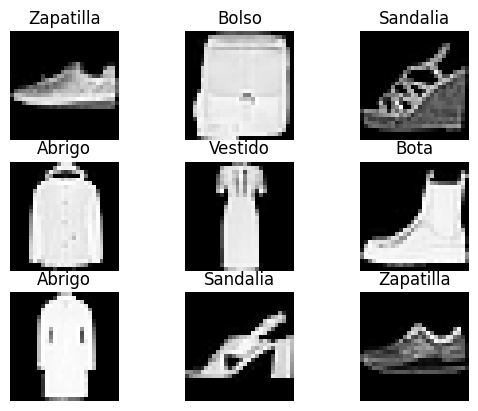

In [ ]:
# Graficamos las muestras con sus etiquetas
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = trainset[j]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

In [ ]:
# Creamos los vectores con los datos predichos y lo que debería ser

def valid_loop(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Para testear, desactivamos el cálculo de gradientes.
    PRED = np.array([])
    ORIG = np.array([])
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # Appendeamos los originales y las predicciones
            PRED = np.append(PRED, pred.argmax(1).cpu().numpy())
            ORIG = np.append(ORIG, y.cpu().numpy())
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            # sum_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            # sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    # avg_loss = sum_loss/num_batches
    # frac_correct = sum_correct/size
    # print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
    return PRED,ORIG

In [ ]:
# Creamos la función pérdida
loss_fn = nn.CrossEntropyLoss()

# Creamos el DataLoader
batch_size = 100
testloader = DataLoader(testset,batch_size = batch_size, shuffle = True)

In [ ]:
image,etiqueta = trainset[0]

In [ ]:
clasificador.eval()
clasificador = clasificador.to(device)
prediccion = clasificador(batch(image).to(device))

In [ ]:
batch(image).to(device)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [ ]:
batch(image).shape

torch.Size([1, 1, 28, 28])

In [ ]:
# Nos generamos la prediccion y el original
prediccion,original = valid_loop(testloader,clasificador,loss_fn)

In [ ]:
prediccion

array([0., 3., 2., ..., 3., 7., 4.])

In [ ]:
# Creamos la matriz confusión y sus representaciones porcentuales
conf_matrix = confusion_matrix(original, prediccion)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100.0

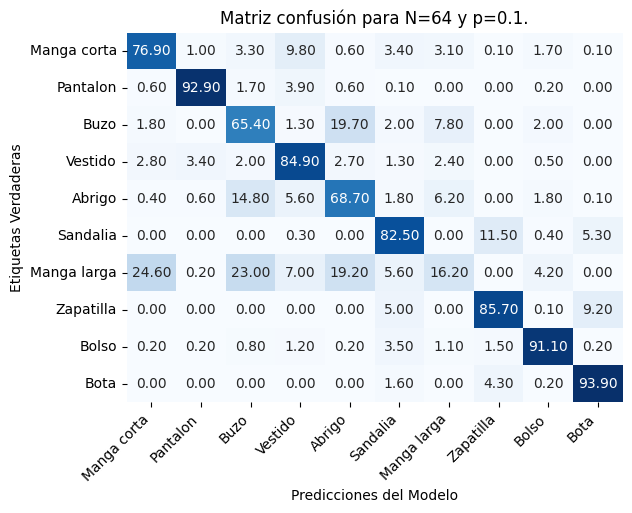

In [ ]:
# figure = plt.figure(figsize = (8,8))

ax = sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=list_names, yticklabels=list_names)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.title('Matriz confusión para N=64 y p=0.1.')
plt.xlabel('Predicciones del Modelo')
plt.ylabel('Etiquetas Verdaderas')
plt.show()

# Visualización del modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation
from keras import layers

import keras
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers

In [ ]:
from PIL import ImageFont
from collections import defaultdict

In [ ]:
# Descargar la fuente (puedes reemplazar la URL con la URL de la fuente que deseas)
!wget -q https://example.com/your_font.ttf

# Mover la fuente descargada al directorio de fuentes de Matplotlib
!mv your_font.ttf /usr/share/fonts/truetype/

# Actualizar la caché de fuentes
!fc-cache -f -v

# Utilizar la fuente en tu código
from PIL import ImageFont


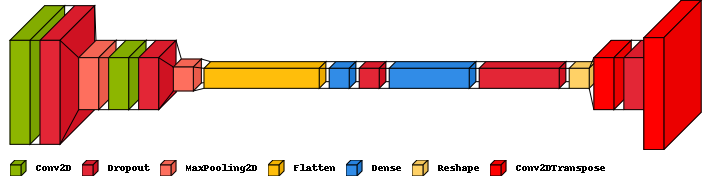

In [ ]:
# Autoencoder

model = Sequential()

# Encoder
model.add(Conv2D(16, (3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=(28, 28, 1)))

model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), strides=(1,1),activation='relu',padding='same',input_shape=(26,26,16),))

model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64,input_shape=(32*5*5,),activation='relu'))

model.add(Dropout(0.2))

# # Decoder
model.add(Dense(32*5*5,input_shape=(64,),activation='relu'))

model.add(Dropout(0.2))
model.add(Reshape((5, 5, 32), input_shape=(32 * 5 * 5,)))
# model.add(Conv2D(32,(3,3), strides=(1,1),activation='relu',padding='same',)
model.add(Conv2DTranspose(16,kernel_size=(4,4),strides=(2,2),output_padding=(1,1), activation='relu',input_shape=(5,5,32),))

model.add(Dropout(0.2))
model.add(Conv2DTranspose(1,kernel_size=(3,3),strides=(2,2),output_padding=(1,1), activation='sigmoid',input_shape=(13,13,16)))

# figure = plt.figure(figsize = (3,3))

color_map = defaultdict(dict) #customize the colours
color_map[layers.Conv2D]['fill'] = '#8db600'#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#fe6f5e'#8338ec'
color_map[layers.Dropout]['fill'] = '#e32636'#03045e'
color_map[layers.Dense]['fill'] = '#318ce7'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
color_map[layers.Conv2DTranspose]['fill'] = '#FF0000'
# font = ImageFont.truetype('arial.ttf',12)
labels ={Conv2D:'Conv2D',Dropout:'Dropout',MaxPooling2D:'MaxPool2d',Flatten:'Flatten',Dense:'Linear',Reshape:'Unflatten',Conv2DTranspose:'ConvTranspose2d'}

visualkeras.layered_view(model, legend=labels,draw_volume=True,color_map=color_map)

# vis = visualkeras.layered_view(model)

# # Cambiar las leyendas
# labels = ['Capa de Entrada'] + ['Densa'] * (len(model.layers) - 2) + ['Capa de Salida']
# vis.legend = labels
# vis

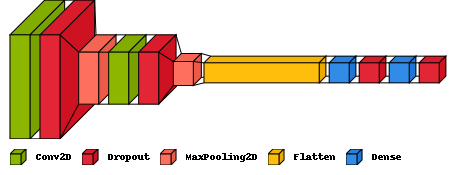

In [ ]:
# Clasificador

model = Sequential()

# Encoder
model.add(Conv2D(16, (3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=(28, 28, 1)))

model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), strides=(1,1),activation='relu',padding='same',input_shape=(26,26,16),))

model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64,input_shape=(32*5*5,),activation='relu'))

model.add(Dropout(0.2))

# cl

model.add(Dense(10,input_shape=(64,),activation='relu'))
model.add(Dropout(0.2))


color_map = defaultdict(dict) #customize the colours
color_map[layers.Conv2D]['fill'] = '#8db600'#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#fe6f5e'#8338ec'
color_map[layers.Dropout]['fill'] = '#e32636'#03045e'
color_map[layers.Dense]['fill'] = '#318ce7'
color_map[layers.Flatten]['fill'] = '#ffbe0b'

# font = ImageFont.truetype('arial.ttf',12)
labels ={Conv2D:'Conv2D',Dropout:'Dropout',MaxPooling2D:'MaxPool2d',Flatten:'Flatten',Dense:'Linear',Reshape:'Unflatten',Conv2DTranspose:'ConvTranspose2d'}

visualkeras.layered_view(model, legend=labels,draw_volume=True,color_map=color_map)#,font = font)

In [ ]:
help(Conv2DTranspose)

Help on class Conv2DTranspose in module keras.src.layers.convolutional.conv2d_transpose:

class Conv2DTranspose(keras.src.layers.convolutional.conv2d.Conv2D)
 |  Conv2DTranspose(filters, kernel_size, strides=(1, 1), padding='valid', output_padding=None, data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |  
 |  Transposed convolution layer (sometimes called Deconvolution).
 |  
 |  The need for transposed convolutions generally arises
 |  from the desire to use a transformation going in the opposite direction
 |  of a normal convolution, i.e., from something that has the shape of the
 |  output of some convolution to something that has the shape of its input
 |  while maintaining a connectivity pattern that is compatible with
 |  said convolution.
 |  
 |  When using this l